# OU score model on Heston IV surfaces — Guided sampling + final denoise + softplus/sum penalties

This notebook implements the OU/score idea on Heston implied-volatility surfaces, and adds **stronger arbitrage guidance** during sampling.

1. **Final denoise output**: after the reverse SDE finishes, output the network’s \(\hat x_0\) instead of the last noisy \(x_t\). This removes the last-step Euler–Maruyama noise that creates small high‑frequency wiggles (which break discrete convexity).  
2. **Softplus + sum penalties** (instead of squared-mean): violations are usually many tiny negatives. Squared-mean gives vanishing gradients. Softplus-hinge + **sum over grid points** gives usable gradients to fix sign.  
3. **Separated guidance** for butterfly and calendar: different time windows and strengths so calendar guidance doesn’t accidentally worsen strike convexity.

Notes:
- Sampling remains **reverse SDE with Euler–Maruyama** (no probability-flow ODE).

In [1]:
# ============ Imports & setup ============
import os, math, time
from dataclasses import dataclass
from typing import Tuple, Optional, Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

def set_seed(seed: int = 1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


In [2]:
# ============ Global config ============
@dataclass
class CFG:
    # Market
    S0: float = 100.0
    r: float = 0.01

    # Grid
    K_min: float = 70.0
    K_max: float = 130.0
    nK: int = 13
    T_min: float = 0.25
    T_max: float = 1.00
    nT: int = 10

    # Heston parameter ranges (synthetic)
    kappa_base: float = 2.0
    theta_base: float = 0.04
    eta_base: float = 0.5
    v0_base: float = 0.04
    rho_base: float = -0.7

    # dataset size / caching
    n_surfaces: int = 600
    cache_path: str = "heston_ou_logomega_cache_v4.npz"

    # OU forward SDE parameters
    alpha: float = 0.8
    beta: float = 1.0
    t_max: float = 5.0
    t_min: float = 0.02

    # Training
    batch_size: int = 32
    epochs: int = 250
    lr: float = 2e-4
    ema_decay: float = 0.999

    # UNet
    base_ch: int = 64
    time_emb_dim: int = 128

    # Sampling
    n_steps: int = 8000
    guide_apply_every: int = 1

    # Guidance windows/strength (separate for bfly & cal)
    guide_tmax_bfly: float = 0.5
    guide_tmax_cal: float = 2.0
    guide_warmup_bfly: float = 0.0
    guide_warmup_cal: float = 0.0

    guide_scale_bfly: float = 6.0
    guide_scale_cal: float = 2.0

    # Guidance scaling by 1/(sigma+eps)
    guide_sigma_eps: float = 0.03

    # caps/clips
    guide_lambda_max_bfly: float = 1500.0
    guide_lambda_max_cal: float = 400.0
    guide_grad_norm_max_bfly: float = 200.0
    guide_grad_norm_max_cal: float = 120.0

    # Penalty smoothness (auto-calibrated later from real data if None)
    tau_bfly: Optional[float] = None
    tau_cal: Optional[float] = None

    # final denoise
    final_denoise: bool = True

    # checkpoints
    ckpt_path: str = "ou_eps_unet_v4.pt"

cfg = CFG()
K_grid = np.linspace(cfg.K_min, cfg.K_max, cfg.nK).astype(np.float64)
T_grid = np.linspace(cfg.T_min, cfg.T_max, cfg.nT).astype(np.float64)
print("K_grid:", K_grid[:3], "...", K_grid[-3:])
print("T_grid:", T_grid[:3], "...", T_grid[-3:])


K_grid: [70. 75. 80.] ... [120. 125. 130.]
T_grid: [0.25       0.33333333 0.41666667] ... [0.83333333 0.91666667 1.        ]


In [3]:
# ============ Black–Scholes helpers ============
import numpy as np
from scipy.special import erf
def norm_cdf_np(x: np.ndarray) -> np.ndarray:
  return 0.5 * (1.0 + erf(x / math.sqrt(2.0)))


def bs_call_np(S0: float, K: float, T: float, r: float, sigma: float) -> float:
    if T <= 0:
        return max(S0 - K, 0.0)
    sigma = max(float(sigma), 1e-12)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return float(S0 * norm_cdf_np(d1) - K * np.exp(-r * T) * norm_cdf_np(d2))

def implied_vol_bisect_call_np(C: float, S0: float, K: float, T: float, r: float,
                               lo: float = 1e-4, hi: float = 5.0, iters: int = 80) -> float:
    C = float(C)
    if T <= 0:
        return 1e-4
    intrinsic = max(S0 - K * np.exp(-r * T), 0.0)
    C = min(max(C, intrinsic + 1e-12), S0)  # clamp
    flo = bs_call_np(S0, K, T, r, lo) - C
    fhi = bs_call_np(S0, K, T, r, hi) - C
    if flo > 0:
        return lo
    if fhi < 0:
        return hi
    a, b = lo, hi
    fa, fb = flo, fhi
    for _ in range(iters):
        m = 0.5 * (a + b)
        fm = bs_call_np(S0, K, T, r, m) - C
        if fm == 0:
            return m
        if np.sign(fm) == np.sign(fa):
            a, fa = m, fm
        else:
            b, fb = m, fm
    return 0.5 * (a + b)

# Torch versions for differentiable penalties
def norm_cdf_torch(x: torch.Tensor) -> torch.Tensor:
    return 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def bs_call_torch(S0: float, K: torch.Tensor, T: torch.Tensor, r: float, sigma: torch.Tensor) -> torch.Tensor:
    eps = 1e-12
    sigma = torch.clamp(sigma, min=eps)
    sqrtT = torch.sqrt(torch.clamp(T, min=eps))
    d1 = (torch.log(torch.tensor(S0, device=K.device, dtype=K.dtype) / K) + (r + 0.5*sigma*sigma)*T) / (sigma*sqrtT)
    d2 = d1 - sigma*sqrtT
    return torch.tensor(S0, device=K.device, dtype=K.dtype) * norm_cdf_torch(d1) - K*torch.exp(-r*T)*norm_cdf_torch(d2)


In [4]:
# ============ Heston pricing via Fourier integration (Little Heston Trap) ============
def heston_char_func(u: np.ndarray, T: float, S0: float, r: float,
                     kappa: float, theta: float, eta: float, rho: float, v0: float,
                     j: int) -> np.ndarray:
    # Characteristic function E[e^{i u log S_T}] for P1/P2 integrals.
    x0 = np.log(S0)
    a = kappa * theta

    if j == 1:
        uj = 0.5
        bj = kappa - rho*eta
    else:
        uj = -0.5
        bj = kappa

    iu = 1j*u
    d = np.sqrt((rho*eta*iu - bj)**2 - (eta**2)*(2*uj*iu - u*u))

    # Little Heston Trap: use -d and exp(-dT)
    g = (bj - rho*eta*iu - d) / (bj - rho*eta*iu + d)
    expm = np.exp(-d*T)
    one_minus_gexpm = 1 - g*expm
    one_minus_g = 1 - g

    C = (r*iu*T
         + (a/(eta**2))*((bj - rho*eta*iu - d)*T - 2*np.log(one_minus_gexpm/one_minus_g)))
    D = ((bj - rho*eta*iu - d)/(eta**2)) * ((1 - expm) / one_minus_gexpm)
    return np.exp(C + D*v0 + iu*x0)

def heston_call_price_fourier(S0: float, K: float, T: float, r: float,
                              kappa: float, theta: float, eta: float, rho: float, v0: float,
                              u_max: float = 150.0, n_u: int = 4000) -> float:
    if T <= 0:
        return max(S0 - K, 0.0)

    u = np.linspace(1e-9, u_max, n_u)
    du = u[1] - u[0]
    lnK = np.log(K)

    phi1 = heston_char_func(u, T, S0, r, kappa, theta, eta, rho, v0, j=1)
    integrand1 = np.real(np.exp(-1j*u*lnK) * phi1 / (1j*u))
    P1 = 0.5 + (1/np.pi) * np.trapz(integrand1, dx=du)

    phi2 = heston_char_func(u, T, S0, r, kappa, theta, eta, rho, v0, j=2)
    integrand2 = np.real(np.exp(-1j*u*lnK) * phi2 / (1j*u))
    P2 = 0.5 + (1/np.pi) * np.trapz(integrand2, dx=du)

    return float(S0*P1 - K*np.exp(-r*T)*P2)


In [5]:
# ============ Data generation (Heston -> BS IV -> omega=IV*sqrt(T) -> logomega) ============
def sample_heston_params(n: int, cfg: CFG) -> Dict[str, np.ndarray]:
    U = np.random.rand(n, 4)
    Z = np.random.randn(n)

    kappa = cfg.kappa_base * (0.8 + 0.4*U[:,0])
    theta = cfg.theta_base * (0.7 + 0.6*U[:,1])
    eta   = cfg.eta_base   * (0.7 + 0.6*U[:,2])
    v0    = cfg.v0_base    * (0.7 + 0.6*U[:,3])
    rho   = np.clip(cfg.rho_base + 0.1*Z, -0.95, -0.05)
    return dict(kappa=kappa, theta=theta, eta=eta, v0=v0, rho=rho)

def generate_dataset_logomega(cfg: CFG, force_rebuild: bool = False):
    if (not force_rebuild) and os.path.exists(cfg.cache_path):
        data = np.load(cfg.cache_path, allow_pickle=True)
        X = data["X"]
        mu = float(data["mu"])
        sig = float(data["sig"])
        params = data["params"].item()
        print("Loaded cache:", cfg.cache_path, "X:", X.shape)
        return X, params, mu, sig

    print("Generating dataset (this can take time)...")
    params = sample_heston_params(cfg.n_surfaces, cfg)
    n = cfg.n_surfaces
    logomega = np.zeros((n, cfg.nT, cfg.nK), dtype=np.float64)

    t0 = time.time()
    for i in range(n):
        kappa = float(params["kappa"][i])
        theta = float(params["theta"][i])
        eta   = float(params["eta"][i])
        rho   = float(params["rho"][i])
        v0    = float(params["v0"][i])

        for jT, T in enumerate(T_grid):
            sqrtT = math.sqrt(float(T))
            for jK, K in enumerate(K_grid):
                C = heston_call_price_fourier(cfg.S0, float(K), float(T), cfg.r, kappa, theta, eta, rho, v0)
                iv = implied_vol_bisect_call_np(C, cfg.S0, float(K), float(T), cfg.r)
                omega = iv * sqrtT
                logomega[i, jT, jK] = math.log(max(omega, 1e-12))

        if (i+1) % 20 == 0:
            print(f"  {i+1}/{n} surfaces, elapsed {time.time()-t0:.1f}s")

    mu = float(logomega.mean())
    sig = float(logomega.std() + 1e-12)
    X = ((logomega - mu)/sig).astype(np.float32)[:, None, :, :]

    np.savez(cfg.cache_path, X=X, mu=mu, sig=sig, params=params)
    print("Saved cache:", cfg.cache_path, "X:", X.shape, "elapsed", time.time()-t0, "s")
    return X, params, mu, sig

X_data, params, mu_logomega, sig_logomega = generate_dataset_logomega(cfg, force_rebuild=False)
print("X_data:", X_data.shape, "mu:", mu_logomega, "sig:", sig_logomega)


Generating dataset (this can take time)...


/tmp/ipython-input-2638718669.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P1 = 0.5 + (1/np.pi) * np.trapz(integrand1, dx=du)
/tmp/ipython-input-2638718669.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P2 = 0.5 + (1/np.pi) * np.trapz(integrand2, dx=du)


  20/600 surfaces, elapsed 10.7s
  40/600 surfaces, elapsed 21.8s
  60/600 surfaces, elapsed 32.3s
  80/600 surfaces, elapsed 43.3s
  100/600 surfaces, elapsed 53.8s
  120/600 surfaces, elapsed 64.9s
  140/600 surfaces, elapsed 75.7s
  160/600 surfaces, elapsed 86.1s
  180/600 surfaces, elapsed 96.1s
  200/600 surfaces, elapsed 107.0s
  220/600 surfaces, elapsed 117.5s
  240/600 surfaces, elapsed 128.1s
  260/600 surfaces, elapsed 138.9s
  280/600 surfaces, elapsed 149.3s
  300/600 surfaces, elapsed 160.1s
  320/600 surfaces, elapsed 170.8s
  340/600 surfaces, elapsed 181.5s
  360/600 surfaces, elapsed 192.2s
  380/600 surfaces, elapsed 202.7s
  400/600 surfaces, elapsed 213.6s
  420/600 surfaces, elapsed 224.0s
  440/600 surfaces, elapsed 234.9s
  460/600 surfaces, elapsed 245.5s
  480/600 surfaces, elapsed 255.9s
  500/600 surfaces, elapsed 266.8s
  520/600 surfaces, elapsed 276.2s
  540/600 surfaces, elapsed 287.2s
  560/600 surfaces, elapsed 297.7s
  580/600 surfaces, elapsed 308.6

In [6]:
# ============ Torch dataset ============
class SurfaceDataset(Dataset):
    def __init__(self, X: np.ndarray):
        self.X = torch.from_numpy(X)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx]

ds = SurfaceDataset(X_data)
dl = DataLoader(ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
print("dataset size:", len(ds), "batches/epoch:", len(dl))


dataset size: 600 batches/epoch: 18


In [7]:
# ============ UNet (epsilon predictor) ============
def sinusoidal_time_embedding(t: torch.Tensor, dim: int) -> torch.Tensor:
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device).float() / (half - 1 + 1e-12))
    args = t.float() * freqs[None, :]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros((t.shape[0], 1), device=t.device)], dim=1)
    return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, time_dim: int):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_proj = nn.Linear(time_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.time_proj(F.silu(t_emb))[:, :, None, None]
        h = self.conv2(F.silu(self.norm2(h)))
        return h + self.skip(x)

class Down(nn.Module):
    def __init__(self, ch: int):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 4, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, ch: int):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(ch, ch, 4, stride=2, padding=1)
    def forward(self, x):
        return self.deconv(x)

class UNetEps(nn.Module):
    def __init__(self, in_ch: int = 1, base_ch: int = 64, time_dim: int = 128):
        super().__init__()
        self.time_dim = time_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim*4),
            nn.SiLU(),
            nn.Linear(time_dim*4, time_dim),
        )

        c1, c2, c3 = base_ch, base_ch*2, base_ch*4
        self.in_conv = nn.Conv2d(in_ch, c1, 3, padding=1)
        self.rb1 = ResBlock(c1, c1, time_dim)
        self.down1 = Down(c1)
        self.rb2 = ResBlock(c1, c2, time_dim)
        self.down2 = Down(c2)
        self.rb3 = ResBlock(c2, c3, time_dim)
        self.mid = ResBlock(c3, c3, time_dim)

        self.up2 = Up(c3)
        self.rb_up2 = ResBlock(c3 + c2, c2, time_dim)
        self.up1 = Up(c2)
        self.rb_up1 = ResBlock(c2 + c1, c1, time_dim)

        self.out_norm = nn.GroupNorm(8, c1)
        self.out_conv = nn.Conv2d(c1, in_ch, 3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        temb = sinusoidal_time_embedding(t, self.time_dim)
        temb = self.time_mlp(temb)

        x1 = self.rb1(self.in_conv(x), temb)
        x2 = self.rb2(self.down1(x1), temb)
        x3 = self.rb3(self.down2(x2), temb)
        xm = self.mid(x3, temb)

        xu = self.up2(xm)
        if xu.shape[-2:] != x2.shape[-2:]:
            xu = F.interpolate(xu, size=x2.shape[-2:], mode="nearest")
        xu = self.rb_up2(torch.cat([xu, x2], dim=1), temb)

        xu = self.up1(xu)
        if xu.shape[-2:] != x1.shape[-2:]:
            xu = F.interpolate(xu, size=x1.shape[-2:], mode="nearest")
        xu = self.rb_up1(torch.cat([xu, x1], dim=1), temb)

        return self.out_conv(F.silu(self.out_norm(xu)))

model = UNetEps(in_ch=1, base_ch=cfg.base_ch, time_dim=cfg.time_emb_dim).to(device)
print("params:", sum(p.numel() for p in model.parameters())/1e6, "M")


params: 5.092929 M


In [8]:
# ============ EMA ============
class EMA:
    def __init__(self, model: nn.Module, decay: float):
        self.decay = decay
        self.ema_model = UNetEps(in_ch=1, base_ch=cfg.base_ch, time_dim=cfg.time_emb_dim).to(device)
        self.ema_model.load_state_dict(model.state_dict())
        for p in self.ema_model.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update(self, model: nn.Module):
        msd = model.state_dict()
        esd = self.ema_model.state_dict()
        for k in esd.keys():
            esd[k].mul_(self.decay).add_(msd[k], alpha=1.0 - self.decay)

ema = EMA(model, cfg.ema_decay)


No checkpoint found. Training from scratch...
epoch   10 loss 0.040345
epoch   20 loss 0.032476
epoch   30 loss 0.029819
epoch   40 loss 0.027626
epoch   50 loss 0.025172
epoch   60 loss 0.027883
epoch   70 loss 0.025046
epoch   80 loss 0.025061
epoch   90 loss 0.022300
epoch  100 loss 0.022424
epoch  110 loss 0.021936
epoch  120 loss 0.023055
epoch  130 loss 0.022215
epoch  140 loss 0.022428
epoch  150 loss 0.021238
epoch  160 loss 0.020797
epoch  170 loss 0.020213
epoch  180 loss 0.022324
epoch  190 loss 0.020340
epoch  200 loss 0.020714
epoch  210 loss 0.022056
epoch  220 loss 0.022226
epoch  230 loss 0.020892
epoch  240 loss 0.021186
epoch  250 loss 0.021740
Saved checkpoint: ou_eps_unet_v4.pt


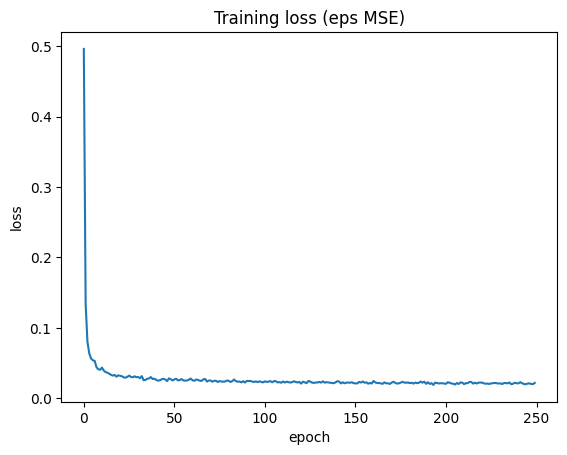

In [9]:
# ============ OU forward marginal & training ============
def ou_coeffs(t: torch.Tensor, alpha: float, beta: float):
    c = torch.exp(-alpha * t)
    sigma2 = (beta**2)/(2*alpha) * (1.0 - torch.exp(-2*alpha*t))
    return c, sigma2

def sample_t_loguniform(batch: int, t_min: float, t_max: float, device: torch.device) -> torch.Tensor:
    u = torch.rand(batch, 1, device=device)
    return t_min * (t_max / t_min) ** u

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

def train_one_epoch(model: nn.Module, ema: EMA, dl: DataLoader, cfg: CFG) -> float:
    model.train()
    losses = []
    for x0 in dl:
        x0 = x0.to(device)
        B = x0.shape[0]
        t = sample_t_loguniform(B, cfg.t_min, cfg.t_max, device)  # (B,1)
        t4 = t[:, :, None, None]
        c, sigma2 = ou_coeffs(t4, cfg.alpha, cfg.beta)
        sigma = torch.sqrt(sigma2 + 1e-12)

        eps = torch.randn_like(x0)
        xt = c * x0 + sigma * eps

        eps_hat = model(xt, t)
        loss = F.mse_loss(eps_hat, eps)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        ema.update(model)
        losses.append(loss.item())
    return float(np.mean(losses))

def save_ckpt(path: str, model: nn.Module, ema: EMA, cfg: CFG, mu: float, sig: float):
    torch.save({
        "model": model.state_dict(),
        "ema": ema.ema_model.state_dict(),
        "cfg": cfg.__dict__,
        "mu": mu,
        "sig": sig,
    }, path)

def load_ckpt(path: str, model: nn.Module, ema: EMA):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    ema.ema_model.load_state_dict(ckpt["ema"])
    return ckpt

if os.path.exists(cfg.ckpt_path):
    print("Found checkpoint:", cfg.ckpt_path)
    ckpt = load_ckpt(cfg.ckpt_path, model, ema)
    print("Loaded.")
else:
    print("No checkpoint found. Training from scratch...")
    tr = []
    for ep in range(cfg.epochs):
        loss = train_one_epoch(model, ema, dl, cfg)
        tr.append(loss)
        if (ep+1) % 10 == 0:
            print(f"epoch {ep+1:4d} loss {loss:.6f}")
    save_ckpt(cfg.ckpt_path, model, ema, cfg, mu_logomega, sig_logomega)
    print("Saved checkpoint:", cfg.ckpt_path)

try:
    tr
    plt.figure()
    plt.plot(tr)
    plt.title("Training loss (eps MSE)")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
except NameError:
    pass


In [10]:
# ============ Transform helpers: x (standardized logomega) -> iv surface ============
K_torch = torch.tensor(K_grid, device=device, dtype=torch.float32)[None, None, None, :]
T_torch = torch.tensor(T_grid, device=device, dtype=torch.float32)[None, None, :, None]
sqrtT_torch = torch.sqrt(T_torch)

def x_to_iv(x_std: torch.Tensor, mu: float, sig: float) -> torch.Tensor:
    logomega = x_std * sig + mu
    omega = torch.exp(logomega)
    return omega / (sqrtT_torch + 1e-12)


In [11]:
# ============ Arbitrage penalties (differentiable) ============
def discrete_bfly_curvature(call: torch.Tensor) -> torch.Tensor:
    # call: (B,nT,nK)
    c0 = call[:, :, :-2]
    c1 = call[:, :, 1:-1]
    c2 = call[:, :, 2:]
    dK = float(K_grid[1] - K_grid[0])
    return (c0 - 2*c1 + c2) / (dK*dK)

def discrete_calendar_dw(w: torch.Tensor) -> torch.Tensor:
    return w[:, 1:, :] - w[:, :-1, :]

def penalty_softplus_sum(constraint: torch.Tensor, tau: float, tol: float = 0.0) -> torch.Tensor:
    x = (tol - constraint) / max(tau, 1e-12)
    p = F.softplus(x) * max(tau, 1e-12)
    return p.flatten(1).sum(dim=1)

@torch.no_grad()
def calibrate_taus_from_real(X_std: torch.Tensor, mu: float, sig: float):
    x = X_std.to(device)[:64]
    iv = x_to_iv(x, mu, sig).squeeze(1)  # (B,nT,nK)
    B = iv.shape[0]
    K = torch.tensor(K_grid, device=device, dtype=torch.float32)[None, None, :].expand(B, cfg.nT, cfg.nK)
    T = torch.tensor(T_grid, device=device, dtype=torch.float32)[None, :, None].expand(B, cfg.nT, cfg.nK)
    call = bs_call_torch(cfg.S0, K, T, cfg.r, iv)
    curv = discrete_bfly_curvature(call)
    w = (iv*iv) * T
    dw = discrete_calendar_dw(w)
    curv_scale = float(curv.abs().median().item() + 1e-12)
    dw_scale = float(dw.abs().median().item() + 1e-12)
    return curv_scale, dw_scale, 0.1*curv_scale, 0.1*dw_scale

curv_scale, dw_scale, tau_b_auto, tau_c_auto = calibrate_taus_from_real(torch.from_numpy(X_data), mu_logomega, sig_logomega)
if cfg.tau_bfly is None:
    cfg.tau_bfly = float(tau_b_auto)
if cfg.tau_cal is None:
    cfg.tau_cal = float(tau_c_auto)

print("curv_scale(median abs):", curv_scale, "dw_scale(median abs):", dw_scale)
print("tau_bfly:", cfg.tau_bfly, "tau_cal:", cfg.tau_cal)

def penalties_from_x0hat(x0_hat_std: torch.Tensor, mu: float, sig: float, cfg: CFG):
    iv = x_to_iv(x0_hat_std, mu, sig).squeeze(1)  # (B,nT,nK)
    B = iv.shape[0]
    K = torch.tensor(K_grid, device=iv.device, dtype=iv.dtype)[None, None, :].expand(B, cfg.nT, cfg.nK)
    T = torch.tensor(T_grid, device=iv.device, dtype=iv.dtype)[None, :, None].expand(B, cfg.nT, cfg.nK)

    call = bs_call_torch(cfg.S0, K, T, cfg.r, iv)
    curv = discrete_bfly_curvature(call)  # (B,nT,nK-2)

    w = (iv*iv) * T
    dw = discrete_calendar_dw(w)          # (B,nT-1,nK)

    Pb = penalty_softplus_sum(curv, tau=cfg.tau_bfly, tol=0.0)
    Pc = penalty_softplus_sum(dw,   tau=cfg.tau_cal,  tol=0.0)
    return Pb, Pc


curv_scale(median abs): 0.015379218385623528 dw_scale(median abs): 0.0028184205303655395
tau_bfly: 0.0015379218385623528 tau_cal: 0.00028184205303655397


In [12]:
# ============ Guidance scheduling / clipping ============
def warmup_weight(t: torch.Tensor, tmax: float, warmup: float) -> torch.Tensor:
    w = (t <= tmax).float()
    if warmup <= 0:
        return w
    t1 = tmax * (1.0 - warmup)
    ramp = (tmax - t) / max(tmax - t1, 1e-12)
    ramp = torch.clamp(ramp, 0.0, 1.0)
    return w * ramp

def clip_by_norm_per_sample(g: torch.Tensor, max_norm: float) -> torch.Tensor:
    B = g.shape[0]
    flat = g.view(B, -1)
    n = torch.norm(flat, dim=1, keepdim=True) + 1e-12
    fac = torch.clamp(n, max=max_norm) / n
    return (flat * fac).view_as(g)


In [13]:
# ============ Reverse SDE sampling (v4: final denoise + softplus/sum + split guidance) ============
@torch.no_grad()
def sample_reverse_sde_no_guide(model_eps: nn.Module, cfg: CFG, mu: float, sig: float,
                                n_samples: int = 8, seed: int = 0) -> torch.Tensor:
    set_seed(seed)
    model_eps.eval()

    dt = (cfg.t_max - cfg.t_min) / cfg.n_steps
    var_T = (cfg.beta**2) / (2*cfg.alpha)
    x = torch.randn(n_samples, 1, cfg.nT, cfg.nK, device=device) * math.sqrt(var_T)

    for step in range(cfg.n_steps):
        t_val = cfg.t_max - step*dt
        t = torch.full((n_samples, 1), t_val, device=device)
        t4 = t[:, :, None, None]

        c, sigma2 = ou_coeffs(t4, cfg.alpha, cfg.beta)
        sigma = torch.sqrt(sigma2 + 1e-12)

        eps_hat = model_eps(x, t)
        score = -eps_hat / (sigma + 1e-12)
        drift = cfg.alpha * x + (cfg.beta**2) * score

        z = torch.randn_like(x)
        x = x + drift * dt + cfg.beta * math.sqrt(dt) * z

    if cfg.final_denoise:
        t = torch.full((n_samples, 1), cfg.t_min, device=device)
        t4 = t[:, :, None, None]
        c, sigma2 = ou_coeffs(t4, cfg.alpha, cfg.beta)
        sigma = torch.sqrt(sigma2 + 1e-12)
        eps_hat = model_eps(x, t)
        x0_hat = (x - sigma * eps_hat) / (c + 1e-12)
        return x0_hat
    return x

def sample_reverse_sde_guided_v4(model_eps: nn.Module, cfg: CFG, mu: float, sig: float,
                                 n_samples: int = 8, seed: int = 0,
                                 debug: bool = True) -> torch.Tensor:
    set_seed(seed)
    model_eps.eval()

    dt = (cfg.t_max - cfg.t_min) / cfg.n_steps
    var_T = (cfg.beta**2) / (2*cfg.alpha)
    x = torch.randn(n_samples, 1, cfg.nT, cfg.nK, device=device) * math.sqrt(var_T)

    milestones = [2.5, 1.5, 1.0, 0.7, 0.5, 0.3, 0.2, 0.12, 0.08, 0.05, 0.03, 0.02]
    hit = {m: False for m in milestones}

    for step in range(cfg.n_steps):
        t_val = cfg.t_max - step*dt
        t = torch.full((n_samples, 1), t_val, device=device)
        t4 = t[:, :, None, None]

        c, sigma2 = ou_coeffs(t4, cfg.alpha, cfg.beta)
        sigma = torch.sqrt(sigma2 + 1e-12)

        do_guide = ((step % cfg.guide_apply_every) == 0)

        if do_guide:
            with torch.enable_grad():
                x_req = x.detach().requires_grad_(True)

                eps_hat = model_eps(x_req, t)
                score = -eps_hat / (sigma + 1e-12)

                # x0_hat for penalties: detach eps_hat to avoid Jacobian path
                x0_hat = (x_req - sigma * eps_hat.detach()) / (c + 1e-12)
                Pb, Pc = penalties_from_x0hat(x0_hat, mu, sig, cfg)

                gradB = torch.autograd.grad(Pb.sum(), x_req, retain_graph=True, create_graph=False)[0]
                gradC = torch.autograd.grad(Pc.sum(), x_req, retain_graph=False, create_graph=False)[0]

                gradB = clip_by_norm_per_sample(gradB, cfg.guide_grad_norm_max_bfly)
                gradC = clip_by_norm_per_sample(gradC, cfg.guide_grad_norm_max_cal)

                wB = warmup_weight(t, cfg.guide_tmax_bfly, cfg.guide_warmup_bfly)[:, :, None, None]
                wC = warmup_weight(t, cfg.guide_tmax_cal,  cfg.guide_warmup_cal)[:, :, None, None]
                sigma_scalar = sigma.mean(dim=(2,3), keepdim=True)

                lamB = cfg.guide_scale_bfly * wB / (sigma_scalar + cfg.guide_sigma_eps)
                lamC = cfg.guide_scale_cal  * wC / (sigma_scalar + cfg.guide_sigma_eps)
                lamB = torch.clamp(lamB, max=cfg.guide_lambda_max_bfly)
                lamC = torch.clamp(lamC, max=cfg.guide_lambda_max_cal)

                score_guided = score - lamB * gradB - lamC * gradC
                drift = cfg.alpha * x_req + (cfg.beta**2) * score_guided

                z = torch.randn_like(x_req)
                x = (x_req + drift * dt + cfg.beta * math.sqrt(dt) * z).detach()

                if debug:
                    for m in milestones:
                        if (not hit[m]) and (t_val <= m):
                            hit[m] = True
                            gB = torch.norm(gradB.view(n_samples, -1), dim=1).mean().item()
                            gC = torch.norm(gradC.view(n_samples, -1), dim=1).mean().item()
                            print(f"step {step:5d} t={t_val:6.3f} | Pb={Pb.mean().item():.3e} Pc={Pc.mean().item():.3e} | "
                                  f"lamB={lamB.mean().item():.2f} lamC={lamC.mean().item():.2f} | gB={gB:.2f} gC={gC:.2f}")
                            break
                continue

        # no-guide step
        with torch.no_grad():
            eps_hat = model_eps(x, t)
        score = -eps_hat / (sigma + 1e-12)
        drift = cfg.alpha * x + (cfg.beta**2) * score
        z = torch.randn_like(x)
        x = x + drift * dt + cfg.beta * math.sqrt(dt) * z

        if debug:
            for m in milestones:
                if (not hit[m]) and (t_val <= m):
                    hit[m] = True
                    print(f"step {step:5d} t={t_val:6.3f} | (no guide step)")
                    break

    if cfg.final_denoise:
        t = torch.full((n_samples, 1), cfg.t_min, device=device)
        t4 = t[:, :, None, None]
        c, sigma2 = ou_coeffs(t4, cfg.alpha, cfg.beta)
        sigma = torch.sqrt(sigma2 + 1e-12)
        with torch.no_grad():
            eps_hat = model_eps(x, t)
        x0_hat = (x - sigma * eps_hat) / (c + 1e-12)
        return x0_hat
    return x


In [14]:
# ============ Arbitrage diagnostics (violation ratios) ============
@torch.no_grad()
def arbitrage_violation_ratios(iv: torch.Tensor, cfg: CFG, tol: float = 0.0):
    iv = iv.squeeze(1)
    B = iv.shape[0]
    K = torch.tensor(K_grid, device=iv.device, dtype=iv.dtype)[None, None, :].expand(B, cfg.nT, cfg.nK)
    T = torch.tensor(T_grid, device=iv.device, dtype=iv.dtype)[None, :, None].expand(B, cfg.nT, cfg.nK)

    call = bs_call_torch(cfg.S0, K, T, cfg.r, iv)
    curv = discrete_bfly_curvature(call)
    bfly = (curv < tol).float().mean().item()

    w = (iv*iv)*T
    dw = discrete_calendar_dw(w)
    cal = (dw < tol).float().mean().item()
    return bfly, cal

def plot_surface(iv: np.ndarray, title: str):
    K, T = np.meshgrid(K_grid, T_grid)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(K, T, iv, linewidth=0, antialiased=True)
    ax.set_title(title)
    ax.set_xlabel("K")
    ax.set_ylabel("T")
    ax.set_zlabel("IV")
    plt.show()


step  4017 t= 2.499 | Pb=8.102e-02 Pc=1.334e-02 | lamB=0.00 lamC=0.00 | gB=3.00 gC=0.55
step  5623 t= 1.500 | Pb=1.277e-02 Pc=1.249e-03 | lamB=0.00 lamC=2.55 | gB=0.48 gC=0.07
step  6426 t= 1.000 | Pb=5.786e-03 Pc=3.618e-04 | lamB=0.00 lamC=2.72 | gB=0.13 gC=0.02
step  6908 t= 0.700 | Pb=4.208e-03 Pc=1.264e-04 | lamB=0.00 lamC=2.95 | gB=0.05 gC=0.00
step  7229 t= 0.500 | Pb=3.780e-03 Pc=7.334e-05 | lamB=9.73 lamC=3.24 | gB=0.03 gC=0.00
step  7551 t= 0.300 | Pb=3.581e-03 Pc=6.403e-05 | lamB=11.59 lamC=3.86 | gB=0.02 gC=0.00
step  7711 t= 0.200 | Pb=3.498e-03 Pc=5.802e-05 | lamB=13.52 lamC=4.51 | gB=0.01 gC=0.00
step  7840 t= 0.120 | Pb=3.465e-03 Pc=5.760e-05 | lamB=16.67 lamC=5.56 | gB=0.01 gC=0.00
step  7904 t= 0.080 | Pb=3.456e-03 Pc=5.731e-05 | lamB=19.76 lamC=6.59 | gB=0.01 gC=0.00
step  7952 t= 0.050 | Pb=3.454e-03 Pc=5.710e-05 | lamB=24.10 lamC=8.03 | gB=0.01 gC=0.00
step  7984 t= 0.030 | Pb=3.422e-03 Pc=5.540e-05 | lamB=29.85 lamC=9.95 | gB=0.01 gC=0.00
==== Arbitrage diagnostics

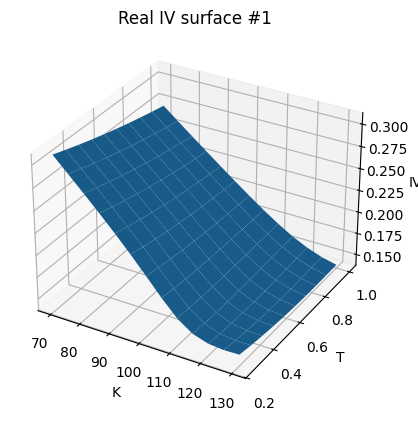

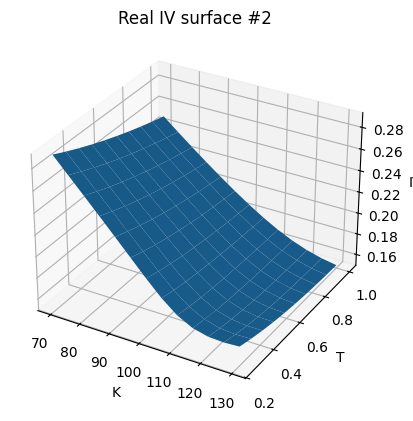

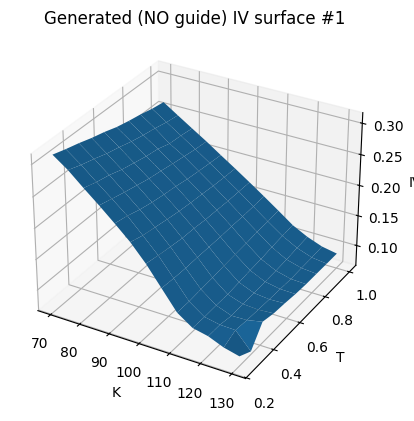

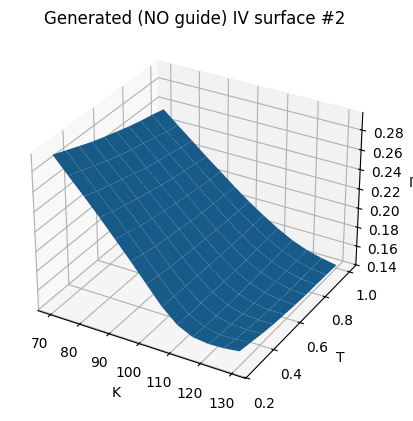

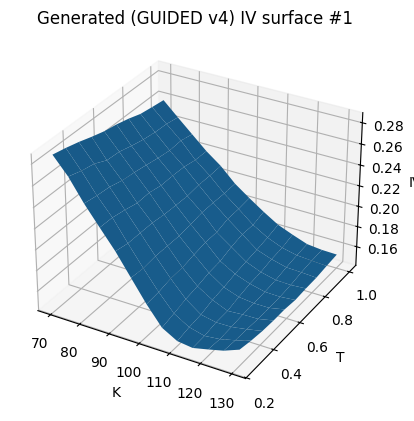

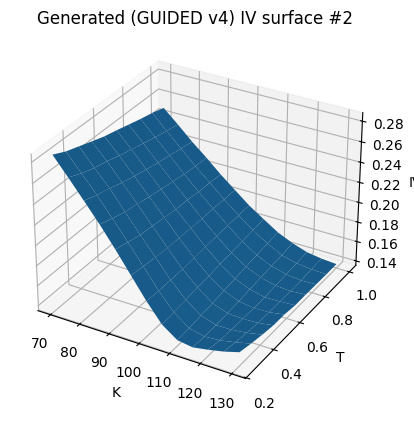

In [15]:
# ============ Sample & evaluate ============
ema_model = ema.ema_model

with torch.no_grad():
    real_batch = torch.from_numpy(X_data[:64]).to(device)
    iv_real = x_to_iv(real_batch, mu_logomega, sig_logomega)
    real_bfly, real_cal = arbitrage_violation_ratios(iv_real, cfg)

x_ng = sample_reverse_sde_no_guide(ema_model, cfg, mu_logomega, sig_logomega, n_samples=64, seed=1)
x_gd = sample_reverse_sde_guided_v4(ema_model, cfg, mu_logomega, sig_logomega, n_samples=64, seed=2, debug=True)

iv_ng = x_to_iv(x_ng, mu_logomega, sig_logomega)
iv_gd = x_to_iv(x_gd, mu_logomega, sig_logomega)

ng_bfly, ng_cal = arbitrage_violation_ratios(iv_ng, cfg)
gd_bfly, gd_cal = arbitrage_violation_ratios(iv_gd, cfg)

print("==== Arbitrage diagnostics (violation ratios) ====")
print(f"Real     | butterfly: {real_bfly*100:.4f}% | calendar: {real_cal*100:.4f}%")
print(f"No guide | butterfly: {ng_bfly*100:.4f}% | calendar: {ng_cal*100:.4f}%")
print(f"Guided   | butterfly: {gd_bfly*100:.4f}% | calendar: {gd_cal*100:.4f}%")

# Plot a few surfaces
n_show = 2
iv_real_np = iv_real[:n_show].squeeze(1).cpu().numpy()
iv_ng_np = iv_ng[:n_show].squeeze(1).cpu().numpy()
iv_gd_np = iv_gd[:n_show].squeeze(1).cpu().numpy()

for i in range(n_show):
    plot_surface(iv_real_np[i], f"Real IV surface #{i+1}")
for i in range(n_show):
    plot_surface(iv_ng_np[i], f"Generated (NO guide) IV surface #{i+1}")
for i in range(n_show):
    plot_surface(iv_gd_np[i], f"Generated (GUIDED v4) IV surface #{i+1}")
